<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, suppress_output

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head(10))

Fetching page 1/15...


Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 999 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 998 articles fetched
Fetching page 6/15...
Page 6: 998 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 998 articles fetched
Fetching page 12/15...
Page 12: 999 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 999 articles fetched
Total articles fetched: 14991


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""LPRO""","""2025-06-01 09:50:00""","""Investors in Open Lending Corp…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""MPLX""","""2025-06-01 09:49:31""","""Change Of Distribution Scenery…","""https://images.financialmodeli…","""seekingalpha.com""","""MPLX's new CEO shifted messagi…","""https://seekingalpha.com/artic…"
"""IOVA""","""2025-06-01 09:45:00""","""Lost Money on Iovance Biothera…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""TMCI""","""2025-06-01 09:45:00""","""Did You Lose Money on Treace M…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""URGN""","""2025-06-01 09:45:00""","""July 28, 2025 Deadline Approac…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""CGC""","""2025-06-01 09:45:00""","""Levi & Korsinsky Urges Canopy …","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""VTRS""","""2025-06-01 09:45:00""","""Class Action Lawsuit Filed Aga…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""WST""","""2025-06-01 09:45:00""","""Join Class Action to Recover L…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""CGC""","""2025-06-01 09:41:00""","""CGC DEADLINE TUESDAY: ROSEN, T…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK CITY, NY / ACCESS New…","""https://www.accessnewswire.com…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

print(f"Sentiment analysis completed for {len(sentiment_df)} stocks")
display(sentiment_df.head(10))

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head(15))
display(sector_summary)

# Export results
# sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
# comprehensive_screened.write_csv("data/screened_stocks.csv")
# print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded 504 stocks, 4296 unique tickers
Analyzing sentiment for stock symbols...
Sentiment analysis completed for 3531 stocks


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles
str,i64,f64,f64,f64,f64,i64
"""SAN""",317,0.5376,0.0536,0.3344,0.0752,317
"""VTRS""",256,0.5603,0.0195,0.5742,0.1207,256
"""IOVA""",256,0.5547,0.0234,0.5273,0.1094,256
"""OTC""",242,0.56,0.0413,0.5537,0.12,242
"""D""",242,0.5573,0.0496,0.4959,0.1146,242
"""AM""",240,0.6445,0.0042,0.8,0.2891,240
"""CIVI""",232,0.5633,0.0172,0.625,0.1266,232
"""NET""",227,0.5388,0.0,0.4714,0.0777,227
"""NVDA""",225,0.5469,0.0844,0.4311,0.0938,225



Screened 1709 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""LPCN""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.5075,0.5688,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""AGS""",3,0.775,0.0,1.0,0.55,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…
"""FWONK""",3,0.75,0.0,1.0,0.5,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""MGMNF""",4,0.748,0.0,1.0,0.496,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""SSRM""",3,0.7456,0.0,1.0,0.4911,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",28,0.59405,0.603164,17.214286,4.2423e10,20.590714
"""Communication Services""",19,0.577263,0.534163,26.421053,3.9629e11,NaN
"""Healthcare""",51,0.574551,0.546006,20.352941,9.1028e10,NaN
"""Technology""",77,0.571757,0.524968,16.545455,2.1723e11,NaN
"""Consumer Cyclical""",50,0.568762,0.507468,13.3,1.1792e11,NaN
…,…,…,…,…,…,…
"""Consumer Defensive""",32,0.560516,0.497478,14.9375,1.0255e11,NaN
"""Energy""",21,0.556838,0.382505,6.095238,7.0078e10,NaN
"""Real Estate""",29,0.554121,0.423997,8.62069,3.6148e10,NaN


### Step 5: Select 10 stocks by sentiment score (bullish and bearish)
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term_portfolio')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head(10))

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution)

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'GS', 'SO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.5075,0.5688,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""ATO""",6,0.7327,0.0,1.0,0.4653,6,0.6032,0.5941,"""Utilities""",2.4434e10,21.48,153.83
"""FI""",4,0.7242,0.0,0.75,0.4484,4,0.525,0.5718,"""Technology""",8.8477e10,28.29,159.58
"""CHTR""",5,0.71,0.0,0.8,0.42,5,0.5342,0.5773,"""Communication Services""",5.5588e10,11.23,402.42
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.525,0.5718,"""Technology""",4.9566e10,21.37,196.2
"""GIS""",4,0.6687,0.0,0.75,0.3375,4,0.4975,0.5605,"""Consumer Defensive""",2.9425e10,11.81,53.74
"""FIS""",6,0.6643,0.0,1.0,0.3286,6,0.525,0.5718,"""Technology""",4.1112e10,49.84,78.25
"""DTE""",18,0.6614,0.0,0.7778,0.3229,18,0.6032,0.5941,"""Utilities""",2.8088e10,18.29,135.35
"""XOM""",11,0.661,0.0,0.9091,0.3221,11,0.3825,0.5568,"""Energy""",4.3898e11,13.51,101.86



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",21,0.251781,0.625914,0.703086
"""Industrials""",16,0.240075,0.620056,0.724181
"""Utilities""",13,0.266954,0.633477,0.714285
"""Healthcare""",12,0.216025,0.608008,0.739217
"""Consumer Cyclical""",11,0.262482,0.631227,0.679009
…,…,…,…,…
"""Financial Services""",5,0.24698,0.62348,0.79696
"""Communication Services""",5,0.29262,0.6463,0.62192
"""Energy""",5,0.25732,0.62864,0.71656



Summary statistics for selected stocks:
Average sentiment score: 0.2479
Min sentiment score: 0.1757
Max sentiment score: 0.5571
Average company news score: 0.6239
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output

quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.head(10))

,bby,ato,fi,chtr,nxpi,gis,fis,dte,xom,ir,...,intu,fe,dltr,ceg,ulta,jnj,apa,ko,dg,ew
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-30,78.123245,109.988556,147.880005,276.109985,266.736328,64.148483,72.693764,108.938644,110.149170,91.917480,...,559.341125,37.408058,114.790001,223.465958,385.579987,140.695847,28.429995,60.170387,124.680206,87.889999
2024-05-31,81.255836,113.241608,149.759995,287.119995,267.394806,66.169662,74.460083,112.590881,113.308990,92.966545,...,572.724304,38.626530,117.949997,215.807175,395.089996,142.041992,29.195013,61.102512,133.421661,86.889999
2024-06-03,83.286743,112.841080,148.470001,286.220001,265.272125,65.207199,74.617081,112.310669,110.593674,89.959244,...,563.563721,38.540180,120.980003,206.876862,389.910004,143.078232,28.152678,61.102512,136.004135,87.860001
2024-06-04,84.158501,113.212303,147.990005,280.600006,261.695099,65.582550,74.646523,112.590881,108.873642,87.881111,...,568.372559,38.578560,120.300003,201.790878,389.410004,143.136337,27.693665,62.083176,131.082809,87.410004
2024-06-05,85.202705,112.352638,149.309998,278.100006,270.932526,64.928078,74.538582,110.668144,109.308487,89.649529,...,570.568298,37.839798,114.379997,207.939774,387.160004,141.364075,27.731918,62.063755,130.995087,87.070000
2024-06-06,84.455490,112.782471,150.559998,279.359985,267.306335,64.860703,74.940926,109.701942,110.129852,88.300728,...,568.958679,37.513592,112.370003,201.254471,384.880005,141.799881,27.951859,62.287083,126.229698,87.680000
2024-06-07,84.225571,112.127945,151.419998,276.829987,267.188416,64.928078,76.059578,108.532852,108.950958,89.050049,...,570.200623,37.244957,111.290001,196.685013,382.609985,142.439056,27.588476,62.054050,123.384094,88.139999
2024-06-10,83.487930,112.811775,149.600006,276.070007,272.062653,64.389107,76.197609,108.832367,109.269836,91.108215,...,563.583557,37.350491,110.190002,213.204559,382.500000,142.487488,28.181364,61.743347,124.436569,86.099998
2024-06-11,83.449608,113.075539,148.000000,276.829987,273.123962,64.466103,74.758240,109.895180,108.390503,91.298042,...,563.047119,37.244957,109.639999,216.860123,387.690002,142.129150,28.391745,61.704502,123.540016,87.000000


### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail(5))

Calculating indicators for bby...
Calculating indicators for ato...
Calculating indicators for fi...
Calculating indicators for chtr...
Calculating indicators for nxpi...
Calculating indicators for gis...
Calculating indicators for fis...
Calculating indicators for dte...
Calculating indicators for xom...
Calculating indicators for ir...
Calculating indicators for nvr...
Calculating indicators for mpc...
Calculating indicators for ual...
Calculating indicators for wec...
Calculating indicators for has...
Calculating indicators for kkr...
Calculating indicators for frt...
Calculating indicators for peg...
Calculating indicators for trmb...
Calculating indicators for dis...
Calculating indicators for duk...
Calculating indicators for ndaq...
Calculating indicators for lhx...
Calculating indicators for gev...
Calculating indicators for exc...
Calculating indicators for cnc...
Calculating indicators for wbd...
Calculating indicators for vz...
Calculating indicators for gen...
Calculating i

,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-23,69.919998,69.8850,68.353316,82.888460,70.671606,69.689109,70.661822,13.754470,50.782719,49.217281,50.782719,49.738551
2025-05-27,72.220001,70.1220,68.385867,82.859095,70.909820,69.876582,70.722928,13.779281,57.050909,42.949091,57.050909,53.703091
2025-05-28,71.519997,70.3640,68.359390,82.817231,71.003694,69.998316,70.754185,13.475742,54.764869,45.235131,54.764869,52.382686
2025-05-29,66.320000,70.3455,68.241552,82.743705,70.283125,69.725849,70.580296,13.731621,41.470973,58.529027,41.470973,43.953380
2025-05-30,66.279999,70.3075,68.109880,82.682221,69.667260,69.470600,70.411656,13.981114,41.387744,58.612256,41.387744,43.896326


### Step 8: Backtest Strategies
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'min_cagr': 0.1,        # Minimum 10% CAGR
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 10        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

STRATEGY BACKTESTING ANALYSIS

🔄 Running strategy backtests...
🔄 Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
✅ Backtesting completed

🔄 Portfolio Construction
📊 CAGR Filtering: 100 → 57 tickers (≥10.0%)
📊 Volatility Filtering: → 39 tickers (≤30.0%)
🏆 Selected top 10 performers:
  #1. cnp: 44.60% CAGR, 19.97% Vol, Sharpe: 1.96 (EMA_Cross_Signal)
  #2. gild: 42.95% CAGR, 25.17% Vol, Sharpe: 1.55 (EMA_Cross_Signal)
  #3. nvr: 37.11% CAGR, 23.07% Vol, Sharpe: 1.49 (SMA_Cross_Signal)
  #4. pm: 36.10% CAGR, 24.98% Vol, Sharpe: 1.37 (EMA_Cross_Signal)
  #5. fis: 35.83% CAGR, 25.11% Vol, Sharpe: 1.35 (SMA_Cross_Signal)
  #6. ndaq: 32.96% CAGR, 23.42% Vol, Sharpe: 1.34 (EMA_Cross_Signal)
  

,cagr,total_return,max_drawdown,sharpe_ratio,volatility,strategy
cnp,0.445980,0.447076,-0.086500,1.958108,0.199694,EMA_Cross_Signal
gild,0.429499,0.430548,-0.178775,1.554255,0.251708,EMA_Cross_Signal
nvr,0.371052,0.371941,-0.103269,1.492007,0.230705,SMA_Cross_Signal
pm,0.361046,0.361908,-0.234092,1.367342,0.249787,EMA_Cross_Signal
fis,0.358282,0.359136,-0.119635,1.349908,0.251136,SMA_Cross_Signal
ndaq,0.329605,0.330383,-0.138756,1.340860,0.234192,EMA_Cross_Signal
anet,0.306015,0.306731,-0.096810,1.132834,0.265629,RSI_Signal
lmt,0.295949,0.296639,-0.132242,1.295686,0.219787,SMA_Cross_Signal
fcx,0.287298,0.287966,-0.058374,1.472064,0.183269,RSI_Signal
amd,0.286572,0.287238,-0.088035,1.079278,0.263510,RSI_Signal


✅ Strategy Analysis Complete!

📈 Portfolio: 10 stocks
  📊 Avg CAGR: 34.71% | Avg Sharpe: 1.40 | Avg Volatility: 23.49% | Avg Drawdown: -12.36%
  🎯 Strategy Distribution:
    - EMA_Cross_Signal: 4 stocks (40.0%)
    - SMA_Cross_Signal: 3 stocks (30.0%)
    - RSI_Signal: 3 stocks (30.0%)


### Step 9: Plot the Best Strategies

📊 Generating Portfolio Charts...

📈 Portfolio Performance:


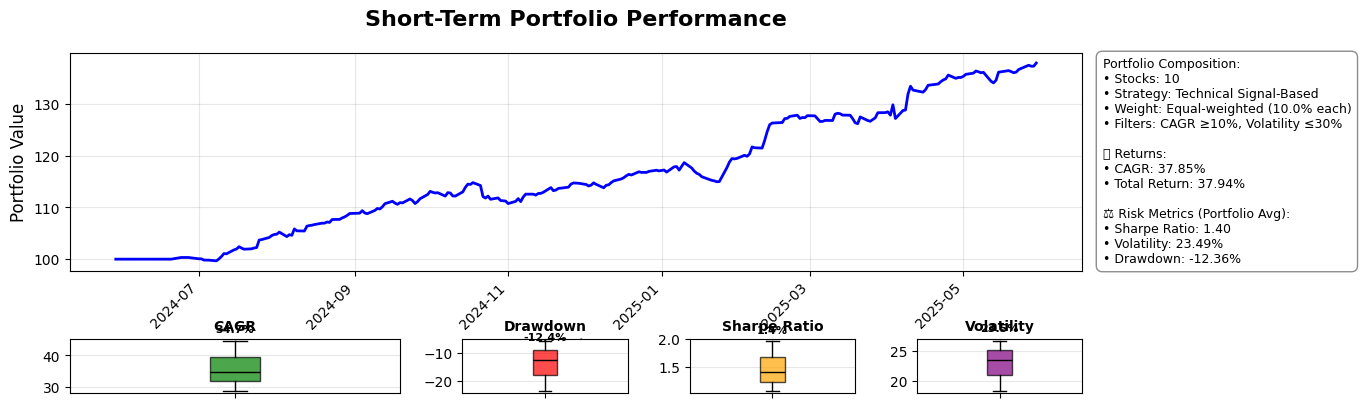


📈 Strategy Signals by Ticker:
📋 Included tickers: ['cnp', 'gild', 'nvr', 'pm', 'fis', 'ndaq', 'anet', 'lmt', 'fcx', 'amd']
📊 Plotting 10 tickers that passed the 10% CAGR and ≤30% volatility thresholds


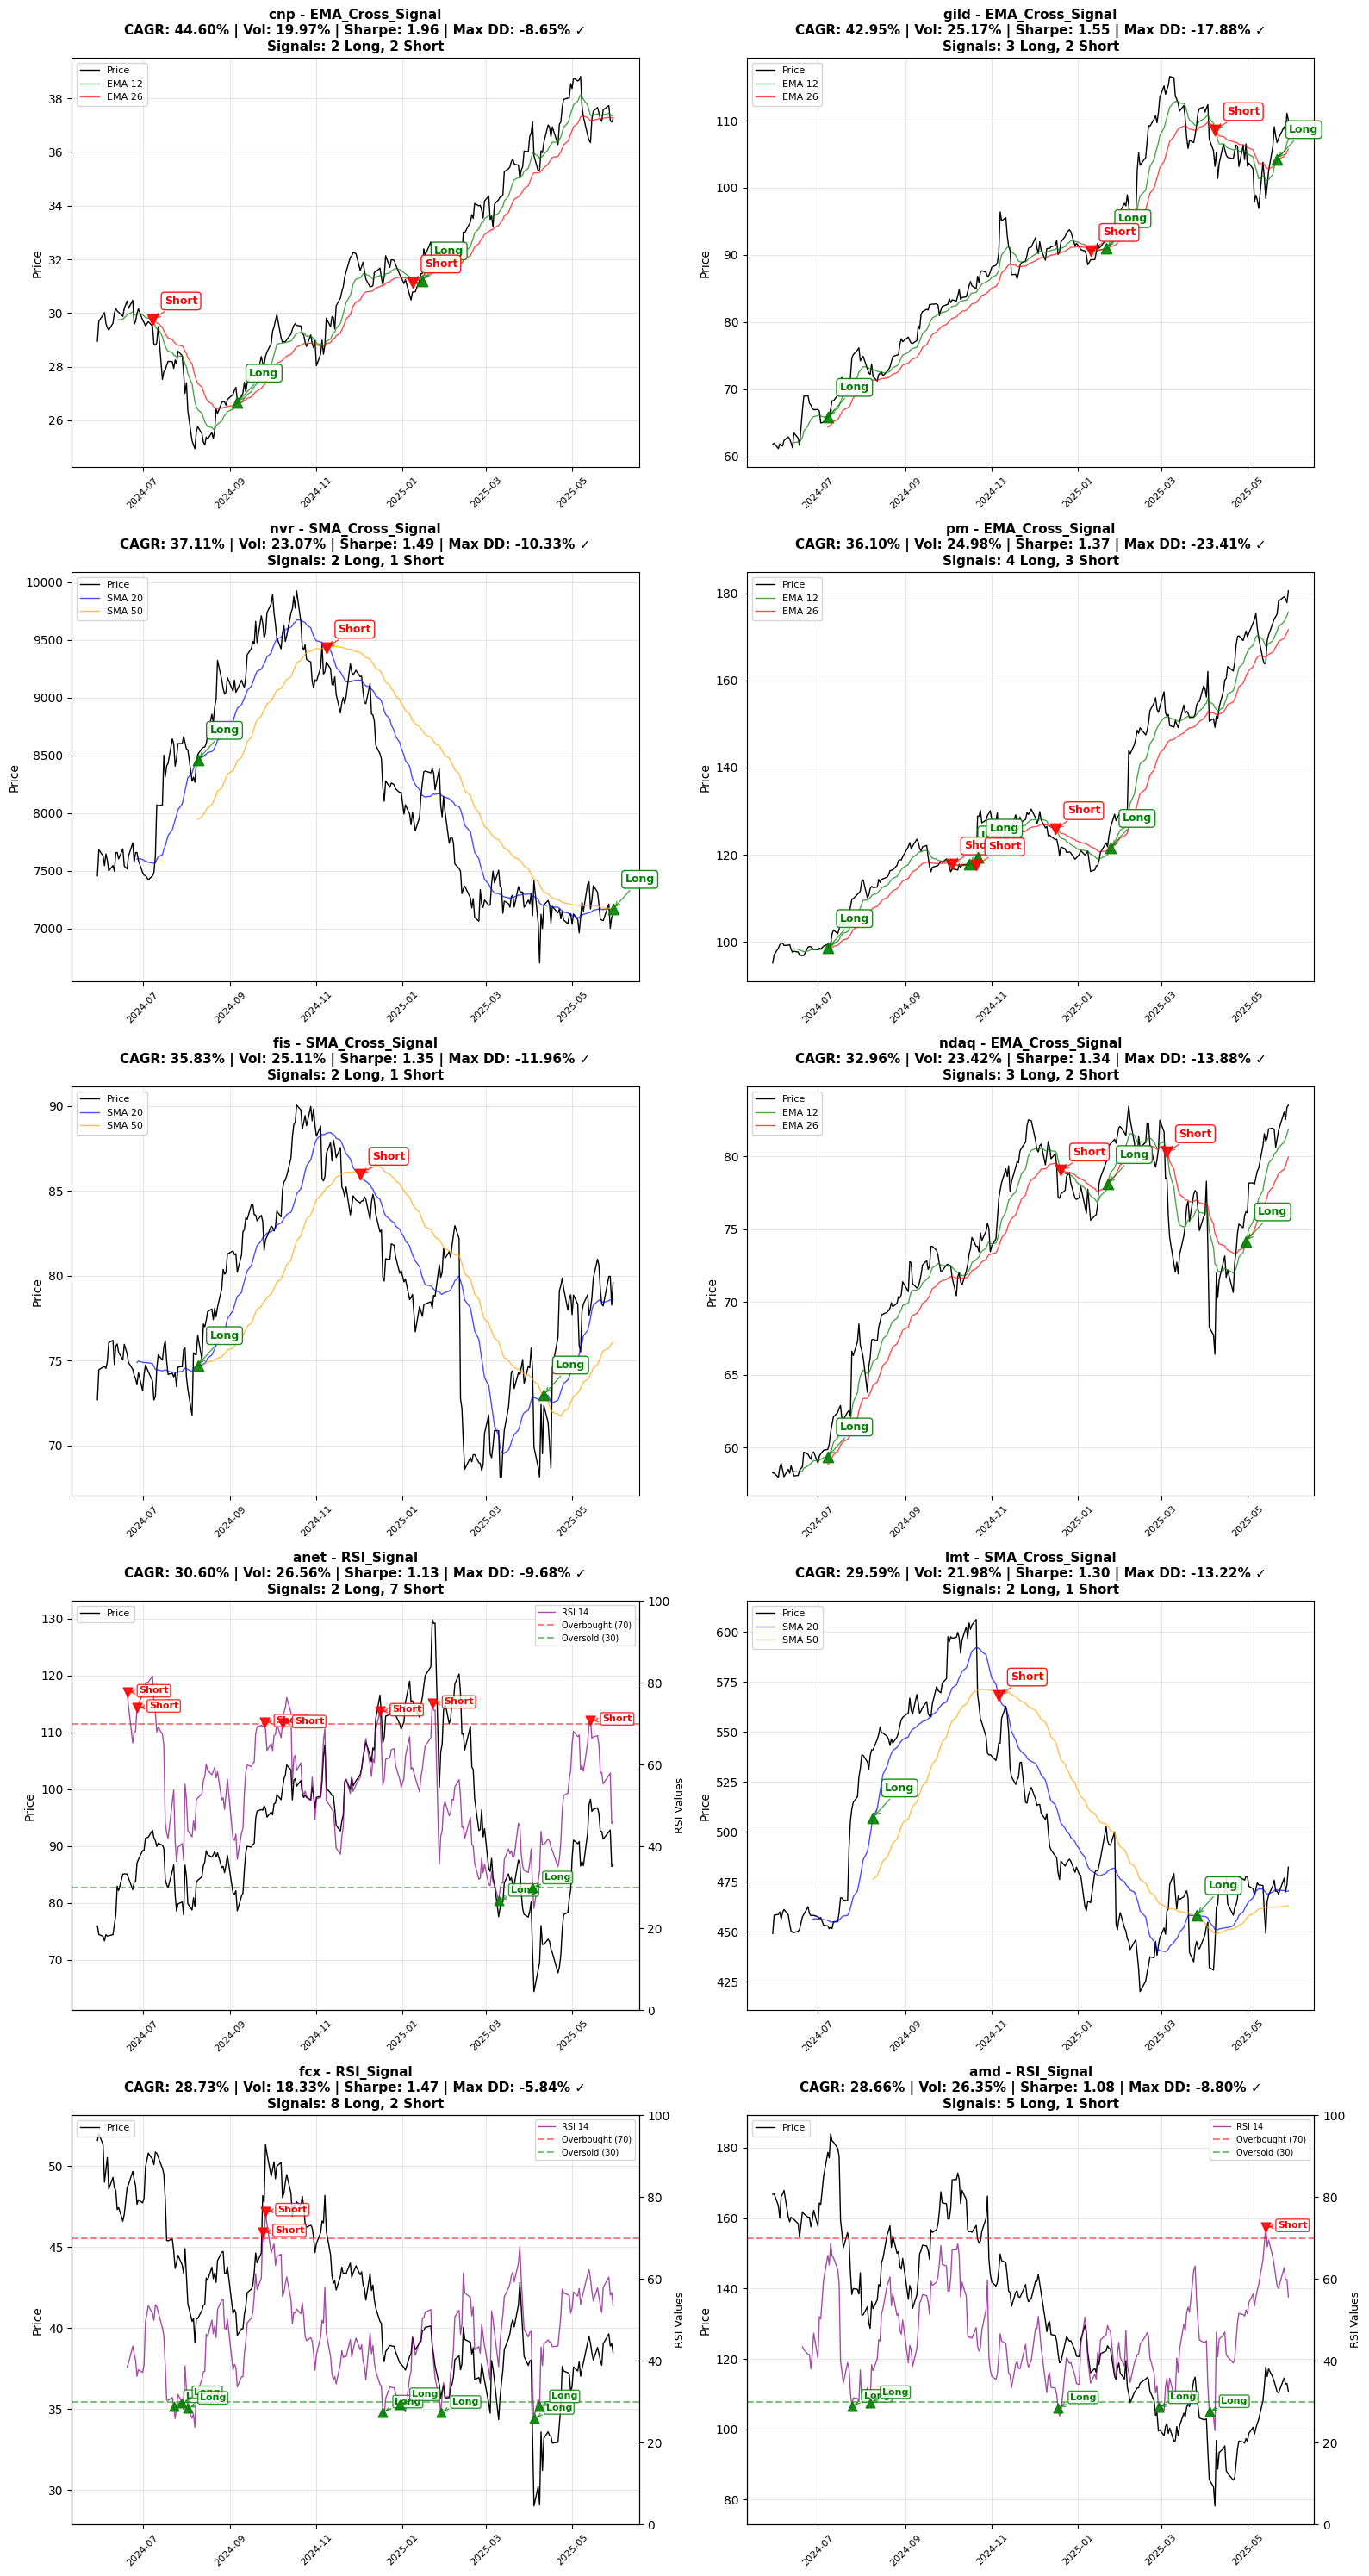


✅ Chart generation complete!


In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_ticker_signals_with_annotations

# Chart generation
print("📊 Generating Portfolio Charts...")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(analysis_results)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             analysis_results['best_strategies'], analysis_results['included_tickers'])
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 all(key in analysis_results for key in ['best_strategies', 'included_tickers']),
                                 analysis_results['included_tickers']]) 
                          else print("⚠️ Missing required data or no tickers passed thresholds"))]:
    try:
        print(f"\n📈 {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and analysis_results.get('included_tickers'):
            print(f"📋 Included tickers: {analysis_results['included_tickers']}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n✅ Chart generation complete!")

### Step 11: Plot the Portfolio Weights

In [13]:
# Calculate industry weights
industry_df = pd.DataFrame({
    'Ticker': filtered_tickers,
    'Weight': filtered_weights,
    'Sector': [fundamentals_df.loc[ticker, 'Sector'] for ticker in filtered_tickers]
})
sector_weights = industry_df.groupby('Sector')['Weight'].sum()
industries = sector_weights.index.tolist()
weights = sector_weights.values.tolist()

NameError: name 'filtered_tickers' is not defined

In [ ]:
# Plot asset allocation
plot_portfolio_weights(
    filtered_tickers, 
    filtered_weights,
    'Portfolio Weight Allocation (By Asset)', 
    'Assets',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=0,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

# Plot sector allocation
plot_portfolio_weights(
    industries, 
    weights,
    'Portfolio Weight Allocation (By Sector)', 
    'Industries',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=45,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [ ]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = daily_prices_df[filtered_tickers].join(daily_risk_free_df, how='inner')

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

#### Export DataFrame to Excel

In [ ]:
# Create a single Excel file with multiple sheets
with pd.ExcelWriter(output_file) as writer:
    # Each DataFrame goes to a different sheet
    optimal_portfolio_df.to_excel(writer, sheet_name='equity')

    # Export daily_quotes
    daily_prices_df_merged.to_excel(writer, sheet_name='daily_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export risk_free
    last_risk_free_df.to_excel(writer, sheet_name='risk_free')